In [20]:
import time
import klepto
import shelve
import pickle
import h5py
import numpy as np
from scipy.sparse import *
import matplotlib.pyplot as plt

In [21]:
dataset = '1m'

In [22]:
feature=h5py.File('movielens/' + dataset + '/test_list.mat')  
test_list = feature['test_list'][:]
test_list = list(map(int, test_list.T[0]))
test_list = [i-1 for i in test_list] 

In [23]:
rating_matrix_csc = load_npz('movielens/sparse_matrix_ml-' + dataset + '_selected.npz').tocsc()
rating_matrix_csc_test  = rating_matrix_csc[:, test_list]
print("file load DONE")

file load DONE


In [24]:
feature=h5py.File('MF_matrix_input_1M.mat')  
MF_matrix_input = feature['MF_matrix'][:].T

In [8]:
row = MF_matrix_input[:, 1]
col = MF_matrix_input[:, 0]
data = MF_matrix_input[:, 2]
input_matrix = csc_matrix((data, (row, col)), shape=rating_matrix_csc.shape)
del rating_matrix_csc
input_matrix

<6040x3700 sparse matrix of type '<class 'numpy.float32'>'
	with 696469 stored elements in Compressed Sparse Column format>

In [9]:
train_list = []
for i in range(MF_matrix_input.shape[0]):
    train_list.append((MF_matrix_input[i, 0], MF_matrix_input[i, 1], MF_matrix_input[i, 2]))
del MF_matrix_input

## MF part

In [10]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS

class MatrixFactorization:
    def __init__(self, maxIter=15, regParam=0.01, rank=10):
        self.maxIter = maxIter
        self.regParam = regParam
        self.rank = rank
        conf = SparkConf().setAppName("appName").setMaster("local[*]")
        conf.set("spark.driver.memory","16g")
        conf.set("spark.executor.memory","16g")
        self.spark = SparkContext(conf=conf)                    
        print("New SparkSession started...")

    def change_parameter(self, regParam):
        self.regParam = regParam

    def matrix_factorization(self, train_lst):
        ratings = self.spark.parallelize(train_lst)
        model = ALS.train(ratings, self.rank, seed=10, \
                          iterations=self.maxIter, \
                          lambda_=self.regParam)
        print("MF DONE")
        userFeatures = sorted(model.userFeatures().collect(), key=lambda d: d[0], reverse=False)
        productFeatures = sorted(model.productFeatures().collect(), key=lambda d: d[0], reverse=False)
        itemProfile = {each[0]: each[1].tolist() for each in userFeatures}
        userProfile = {each[0]: each[1].tolist() for each in productFeatures}
             
        return userProfile, itemProfile

    def end(self):
        self.spark.stop()
        print("SparkSession stopped.")

In [11]:
lambda_list = [0.05, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]

In [15]:
MF = MatrixFactorization()

New SparkSession started...


In [17]:
min_RMSE = -1
rmse_list = []
for plambda in lambda_list:
    print("Current plambda: " + str(plambda))
    MF.change_parameter(plambda)
    user_profile, item_profile = MF.matrix_factorization(train_list)
    
    P_test = np.zeros(rating_matrix_csc_test.shape)
    rating_matrix_test_unqueried = rating_matrix_csc_test.tolil()
    for i in range(len(test_list)):    
        if i % 100 == 0:
            print("%.2f%%" % (100 * i / len(test_list)))  
        rated_user = input_matrix[:, test_list[i]].nonzero()[0]
        if test_list[i] in item_profile:
            P_test[:, i] = np.dot(np.array(list(user_profile.values())), np.array(list(item_profile[test_list[i]])))
            rating_matrix_test_unqueried[rated_user, i] = 0
        else:
            rating_matrix_test_unqueried[:, i] = 0
    rating_matrix_test_unqueried = rating_matrix_test_unqueried.tocsc()
    P_test = (rating_matrix_test_unqueried!=0).multiply(P_test)
    dif = P_test - rating_matrix_test_unqueried
    RMSE = ( dif.multiply(dif).sum() / (rating_matrix_test_unqueried!=0).sum() )**0.5
    # RMSE =  (rmse_nominator / (rating_matrix_test_unqueried!=0).sum() )**0.5
    print("Current RMSE: " + str(RMSE))
    rmse_list.append(RMSE)
    if min_RMSE == -1 or RMSE < min_RMSE:
        min_RMSE = RMSE
        min_lambda = plambda

print("min RMSE: " + str(min(rmse_list)))

plt.figure(1)
plt.title('')
plt.xlabel('plambda')
plt.ylabel('RMSE')
plt.plot(lambda_list, rmse_list)
plt.show()

Current plambda: 0.05
MF DONE
0.00%
9.01%
18.02%
27.03%
36.04%
45.05%
54.05%
63.06%
72.07%
81.08%
90.09%
99.10%
Current RMSE: 1.34081218481
Current plambda: 0.1
MF DONE
0.00%
9.01%
18.02%
27.03%
36.04%
45.05%
54.05%
63.06%
72.07%
81.08%
90.09%
99.10%
Current RMSE: 1.23802186561
Current plambda: 0.11
MF DONE
0.00%
9.01%
18.02%
27.03%
36.04%
45.05%
54.05%
63.06%
72.07%
81.08%
90.09%
99.10%
Current RMSE: 1.22067767889
Current plambda: 0.12
MF DONE
0.00%
9.01%
18.02%
27.03%
36.04%
45.05%
54.05%
63.06%
72.07%
81.08%
90.09%
99.10%
Current RMSE: 1.20514682362
Current plambda: 0.13
MF DONE
0.00%
9.01%
18.02%
27.03%
36.04%
45.05%
54.05%
63.06%
72.07%
81.08%
90.09%
99.10%
Current RMSE: 1.19140724688
Current plambda: 0.14
MF DONE
0.00%
9.01%
18.02%
27.03%
36.04%
45.05%
54.05%
63.06%
72.07%
81.08%
90.09%
99.10%
Current RMSE: 1.18007285603
Current plambda: 0.15
MF DONE
0.00%
9.01%
18.02%
27.03%
36.04%
45.05%
54.05%
63.06%
72.07%
81.08%
90.09%
99.10%
Current RMSE: 1.17145126632
Current plambda: 0.16

KeyboardInterrupt: 

In [14]:
MF.end()

SparkSession stopped.


In [17]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)
Tree['prediction_model'] = prediction_model
Tree.dump()
Tree.clear()

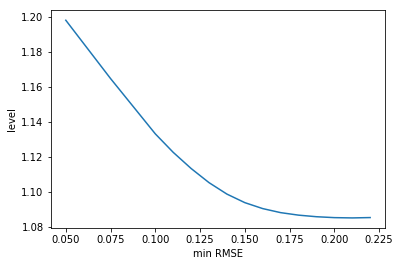

In [23]:
plt.figure(1)
plt.xlabel('min RMSE')
plt.ylabel('level')
plt.plot([0.05, 0.075, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22], rmse_list)
plt.show()

In [27]:
MF = MatrixFactorization()

New SparkSession started...


In [26]:
MF.end()

SparkSession stopped.


In [18]:
plambda = 0.24
print("Current plambda: " + str(plambda))
MF.change_parameter(plambda)
user_profile, item_profile = MF.matrix_factorization(train_list)

P_test = np.zeros(rating_matrix_csc_test.shape)
rating_matrix_test_unqueried = rating_matrix_csc_test.tolil()
for i in range(len(test_list)):    
    if i % 100 == 0:
        print("%.2f%%" % (100 * i / len(test_list)))  
    rated_user = input_matrix[:, test_list[i]].nonzero()[0]
    if test_list[i] in item_profile:
        P_test[:, i] = np.dot(np.array(list(user_profile.values())), np.array(list(item_profile[test_list[i]])))
        rating_matrix_test_unqueried[rated_user, i] = 0
    else:
        rating_matrix_test_unqueried[:, i] = 0
rating_matrix_test_unqueried = rating_matrix_test_unqueried.tocsc()
P_test = (rating_matrix_test_unqueried!=0).multiply(P_test)
dif = P_test - rating_matrix_test_unqueried
RMSE = ( dif.multiply(dif).sum() / (rating_matrix_test_unqueried!=0).sum() )**0.5
print("Current RMSE: " + str(RMSE))

Current plambda: 0.24
MF DONE
0.00%
9.01%
18.02%
27.03%
36.04%
45.05%
54.05%
63.06%
72.07%
81.08%
90.09%
99.10%
Current RMSE: 1.15037992266


In [19]:
nominator = (P_test>3).multiply(rating_matrix_test_unqueried>3).sum()
denominator = (rating_matrix_test_unqueried>3).sum()
nominator/denominator

0.78563524105350724